# Predicción de Riesgo de Enfermedad Cardíaca con Regresión Logística

En este notebook se implementa un modelo de regresión logística desde cero para predecir la presencia de enfermedad cardíaca a partir de variables clínicas. El flujo de trabajo incluye análisis exploratorio de datos (EDA), preprocesamiento, entrenamiento del modelo, regularización y evaluación.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Step 1: Carga y Preparación del Dataset

In [4]:
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


El dataset fue cargado correctamente desde el archivo CSV y contiene información clínica de pacientes, incluyendo edad, presión arterial, colesterol y diagnóstico de enfermedad cardíaca.

### Exploración inicial del dataset


In [5]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    str    
dtypes: float64(1), int64(12), str(1)
memo

El dataset contiene 270 observaciones y 14 variables. La mayoría de las variables son numéricas y no se observan valores faltantes.

### Binarización de la variable objetivo
La variable objetivo *Heart Disease* se transformó a un formato binario, donde:
- 1 indica presencia de enfermedad cardíaca
- 0 indica ausencia de enfermedad cardíaca

In [6]:
df["Heart Disease"] = df["Heart Disease"].map({
    "Presence": 1,
    "Absence": 0
})

In [7]:
df["Heart Disease"].value_counts()

Heart Disease
0    150
1    120
Name: count, dtype: int64

### Distribución de la variable objetivo
Se analiza la proporción de pacientes con y sin enfermedad cardíaca para identificar posibles desbalances de clase.

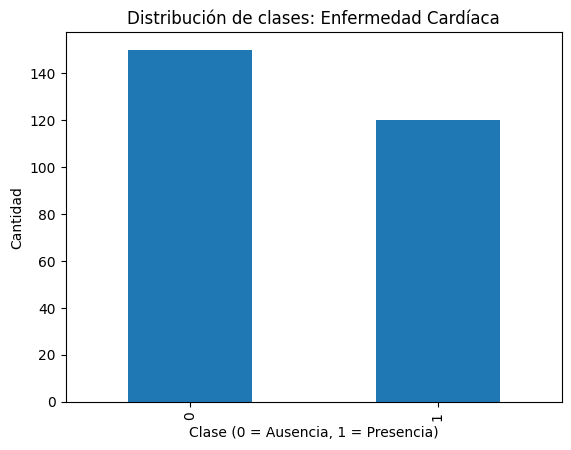

In [8]:
y_counts = df["Heart Disease"].value_counts()

y_counts.plot(kind="bar")
plt.title("Distribución de clases: Enfermedad Cardíaca")
plt.xlabel("Clase (0 = Ausencia, 1 = Presencia)")
plt.ylabel("Cantidad")
plt.show()

La distribución de clases muestra una ligera diferencia entre pacientes con y sin enfermedad cardíaca, sin presentar un desbalance severo que requiera técnicas adicionales de balanceo.

### Selección de variables
Se seleccionaron las siguientes variables por su relevancia clínica y su uso frecuente en estudios de riesgo cardiovascular:
- Age
- BP
- Cholesterol
- Max HR
- ST depression
- Number of vessels fluro

In [9]:
features = [
    "Age",
    "BP",
    "Cholesterol",
    "Max HR",
    "ST depression",
    "Number of vessels fluro"
]

X = df[features].values
y = df["Heart Disease"].values

### Normalización de variables
Las variables numéricas fueron normalizadas para tener media cero y desviación estándar uno, con el fin de mejorar la convergencia del algoritmo de descenso por gradiente.

In [10]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X = (X - X_mean) / X_std

### División del conjunto de datos
El conjunto de datos fue dividido en 70% para entrenamiento y 30% para prueba, manteniendo la proporción entre clases.

In [11]:
np.random.seed(42)

indices = np.arange(len(X))
np.random.shuffle(indices)

split = int(0.7 * len(X))

train_idx = indices[:split]
test_idx = indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

## Step 2: Implementación de la Regresión Logística
### Función sigmoide
La función sigmoide transforma cualquier valor real en un valor entre 0 y 1, interpretado como una probabilidad.

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
sigmoid(np.array([-10, 0, 10]))

array([4.53978687e-05, 5.00000000e-01, 9.99954602e-01])

### Función de costo
Se utiliza la entropía cruzada binaria para medir el error entre las probabilidades predichas y las etiquetas reales.

In [14]:
def compute_cost(X, y, w, b):
    m = len(y)
    z = X @ w + b
    y_hat = sigmoid(z)
    
    cost = -(1/m) * np.sum(
        y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8)
    )
    return cost

### Cálculo de gradientes
Se calculan las derivadas parciales del costo respecto a los pesos y el sesgo.

In [15]:
def compute_gradients(X, y, w, b):
    m = len(y)
    z = X @ w + b
    y_hat = sigmoid(z)
    
    dw = (1/m) * (X.T @ (y_hat - y))
    db = (1/m) * np.sum(y_hat - y)
    
    return dw, db

### Descenso por gradiente
Se optimizan los parámetros del modelo minimizando la función de costo.

In [16]:
def gradient_descent(X, y, w, b, alpha, iterations):
    costs = []

    for i in range(iterations):
        dw, db = compute_gradients(X, y, w, b)
        
        w = w - alpha * dw
        b = b - alpha * db
        
        cost = compute_cost(X, y, w, b)
        costs.append(cost)
        
    return w, b, costs

### Entrenamiento del modelo
El modelo se entrena usando descenso por gradiente.

In [17]:
n_features = X_train.shape[1]
w = np.zeros(n_features)
b = 0

alpha = 0.01
iterations = 1500

w, b, costs = gradient_descent(X_train, y_train, w, b, alpha, iterations)

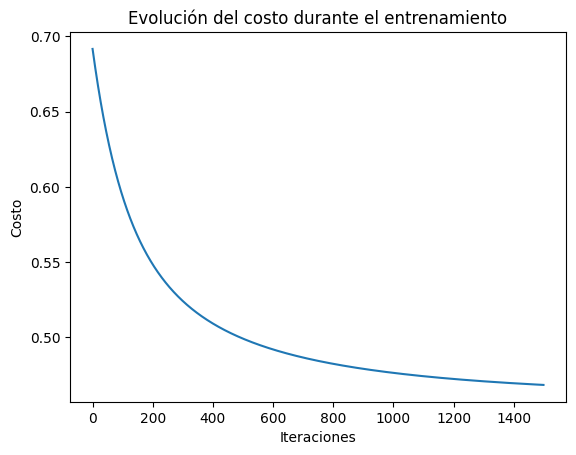

In [18]:
plt.plot(costs)
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Evolución del costo durante el entrenamiento")
plt.show()

### Predicción
Las probabilidades generadas por el modelo se convierten en clases usando un umbral de 0.5.

In [19]:
def predict(X, w, b, threshold=0.5):
    probs = sigmoid(X @ w + b)
    return (probs >= threshold).astype(int)

In [20]:
y_train_pred = predict(X_train, w, b)
y_test_pred = predict(X_test, w, b)

### Métricas de evaluación
Se calculan accuracy, precision, recall y F1-score para evaluar el desempeño del modelo.


In [21]:
def classification_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return accuracy, precision, recall, f1

In [22]:
train_metrics = classification_metrics(y_train, y_train_pred)
test_metrics = classification_metrics(y_test, y_test_pred)

metrics_df = pd.DataFrame(
    [train_metrics, test_metrics],
    columns=["Accuracy", "Precision", "Recall", "F1-score"],
    index=["Train", "Test"]
)

metrics_df

,Accuracy,Precision,Recall,F1-score
Train,0.798942,0.818182,0.675,0.739726
Test,0.753086,0.794118,0.675,0.729730


El modelo presenta un desempeño consistente entre los conjuntos de entrenamiento y prueba, lo que sugiere que no existe un sobreajuste significativo. Las métricas de recall y F1-score son especialmente relevantes en este contexto, ya que priorizan la correcta identificación de pacientes con enfermedad cardíaca.

## Step 3: Visualización de fronteras de decisión
### Edad vs Colesterol
Se entrena un modelo de regresión logística usando únicamente las variables Edad y Colesterol para analizar su capacidad de separación.

In [23]:
features_2d = ["Age", "Cholesterol"]

X_2d = df[features_2d].values
y_2d = df["Heart Disease"].values

In [24]:
X_2d = (X_2d - X_2d.mean(axis=0)) / X_2d.std(axis=0)

In [25]:
X_train_2d = X_2d
y_train_2d = y_2d

In [26]:
w_2d = np.zeros(2)
b_2d = 0

w_2d, b_2d, _ = gradient_descent(
    X_train_2d,
    y_train_2d,
    w_2d,
    b_2d,
    alpha=0.01,
    iterations=1500
)

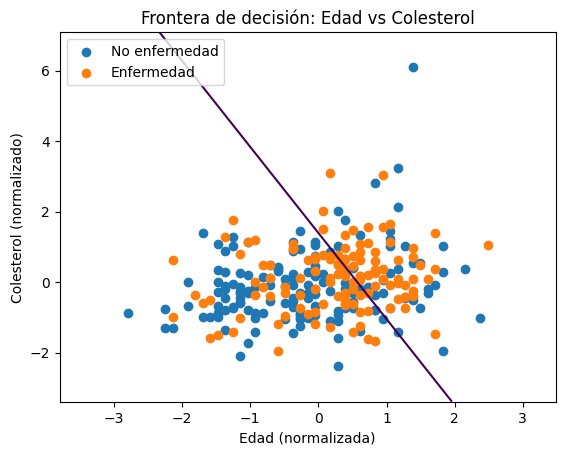

In [27]:
x1_min, x1_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
x2_min, x2_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 200),
    np.linspace(x2_min, x2_max, 200)
)

Z = sigmoid(w_2d[0] * xx1 + w_2d[1] * xx2 + b_2d)
Z = Z.reshape(xx1.shape)

# Gráfica
plt.contour(xx1, xx2, Z, levels=[0.5])
plt.scatter(X_2d[y_2d == 0, 0], X_2d[y_2d == 0, 1], label="No enfermedad")
plt.scatter(X_2d[y_2d == 1, 0], X_2d[y_2d == 1, 1], label="Enfermedad")
plt.xlabel("Edad (normalizada)")
plt.ylabel("Colesterol (normalizado)")
plt.title("Frontera de decisión: Edad vs Colesterol")
plt.legend()
plt.show()

La frontera de decisión muestra una separación parcial entre las clases. Aunque existe cierto solapamiento, se observa que valores altos de colesterol combinados con mayor edad tienden a asociarse con una mayor probabilidad de enfermedad cardíaca.

### Presión arterial vs Frecuencia cardíaca máxima
Se analiza la separabilidad de las clases usando la presión arterial en reposo y la frecuencia cardíaca máxima alcanzada.

In [28]:
features_2d = ["BP", "Max HR"]

X_2d = df[features_2d].values
y_2d = df["Heart Disease"].values

In [29]:
X_2d = (X_2d - X_2d.mean(axis=0)) / X_2d.std(axis=0)

In [30]:
w_2d = np.zeros(2)
b_2d = 0

w_2d, b_2d, _ = gradient_descent(
    X_2d,
    y_2d,
    w_2d,
    b_2d,
    alpha=0.01,
    iterations=1500
)

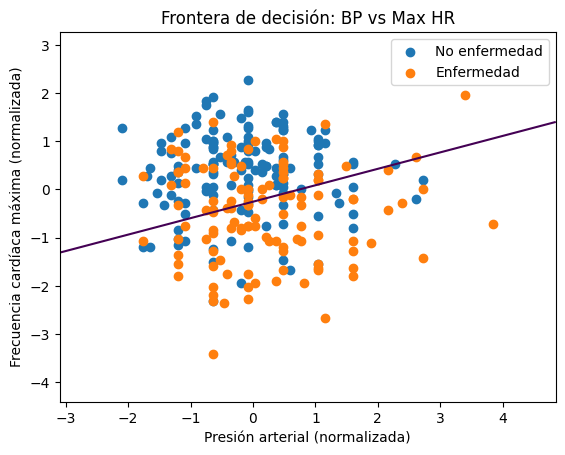

In [31]:
x1_min, x1_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
x2_min, x2_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 200),
    np.linspace(x2_min, x2_max, 200)
)

Z = sigmoid(w_2d[0] * xx1 + w_2d[1] * xx2 + b_2d)
Z = Z.reshape(xx1.shape)

plt.contour(xx1, xx2, Z, levels=[0.5])
plt.scatter(X_2d[y_2d == 0, 0], X_2d[y_2d == 0, 1], label="No enfermedad")
plt.scatter(X_2d[y_2d == 1, 0], X_2d[y_2d == 1, 1], label="Enfermedad")
plt.xlabel("Presión arterial (normalizada)")
plt.ylabel("Frecuencia cardíaca máxima (normalizada)")
plt.title("Frontera de decisión: BP vs Max HR")
plt.legend()
plt.show()

La frontera de decisión indica que pacientes con menor frecuencia cardíaca máxima y mayor presión arterial tienden a presentar un mayor riesgo de enfermedad cardíaca, aunque existe solapamiento entre clases.

### ST depression vs Número de vasos fluoroscópicos
Este par de variables se analiza debido a su fuerte relación clínica con la severidad de la enfermedad cardíaca.

In [32]:
features_2d = ["ST depression", "Number of vessels fluro"]

X_2d = df[features_2d].values
y_2d = df["Heart Disease"].values

In [33]:
X_2d = (X_2d - X_2d.mean(axis=0)) / X_2d.std(axis=0)

In [34]:
w_2d = np.zeros(2)
b_2d = 0

w_2d, b_2d, _ = gradient_descent(
    X_2d,
    y_2d,
    w_2d,
    b_2d,
    alpha=0.01,
    iterations=1500
)

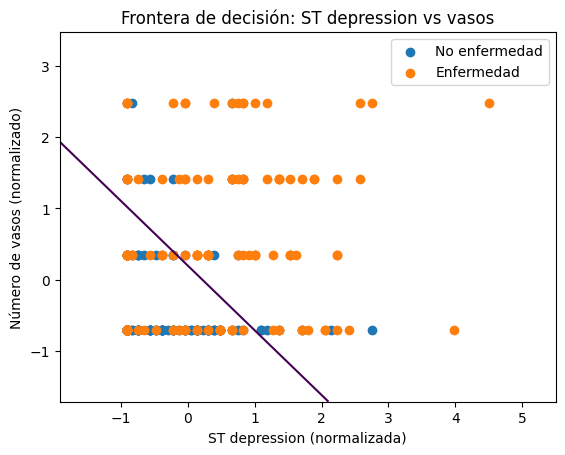

In [35]:
x1_min, x1_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
x2_min, x2_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 200),
    np.linspace(x2_min, x2_max, 200)
)

Z = sigmoid(w_2d[0] * xx1 + w_2d[1] * xx2 + b_2d)
Z = Z.reshape(xx1.shape)

plt.contour(xx1, xx2, Z, levels=[0.5])
plt.scatter(X_2d[y_2d == 0, 0], X_2d[y_2d == 0, 1], label="No enfermedad")
plt.scatter(X_2d[y_2d == 1, 0], X_2d[y_2d == 1, 1], label="Enfermedad")
plt.xlabel("ST depression (normalizada)")
plt.ylabel("Número de vasos (normalizado)")
plt.title("Frontera de decisión: ST depression vs vasos")
plt.legend()
plt.show()

Este par de variables presenta una separación más clara entre las clases. Valores elevados de depresión del ST y un mayor número de vasos afectados se asocian fuertemente con la presencia de enfermedad cardíaca.

## Step 4: Regularización L2

Este paso busca evitar que el modelo se "emocione" demasiado con los datos por así decirlo, que tenga pesos muy grandes y se sobreajuste. Es por eso que L2 castiga pesos grandes y hace que el modelo sea más estable.

In [36]:
def compute_cost_l2(X, y, w, b, lambda_):
    m = X.shape[0]
    y_hat = sigmoid(np.dot(X, w) + b)

    cost = -(1/m) * np.sum(
        y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8)
    )

    l2_cost = (lambda_ / (2 * m)) * np.sum(w ** 2)

    return cost + l2_cost

### Grandiente con regularización

In [37]:
def compute_gradients_l2(X, y, w, b, lambda_):
    m = X.shape[0]
    y_hat = sigmoid(np.dot(X, w) + b)

    dw = (1/m) * np.dot(X.T, (y_hat - y)) + (lambda_ / m) * w
    db = (1/m) * np.sum(y_hat - y)

    return dw, db

### Descenso del gradiente con L2

In [38]:
def gradient_descent_l2(X, y, w, b, alpha, iterations, lambda_):
    costs = []

    for i in range(iterations):
        dw, db = compute_gradients_l2(X, y, w, b, lambda_)

        w -= alpha * dw
        b -= alpha * db

        cost = compute_cost_l2(X, y, w, b, lambda_)
        costs.append(cost)

    return w, b, costs

Ahora vamos a entrenar el modelo regularizado que usa las mismas X_train, y_train del Step 2.

In [39]:
lambda_ = 0.1

w_l2 = np.zeros(X_train.shape[1])
b_l2 = 0

w_l2, b_l2, costs_l2 = gradient_descent_l2(
    X_train,
    y_train,
    w_l2,
    b_l2,
    alpha=0.01,
    iterations=2000,
    lambda_=lambda_
)

Comparamps pesos:

In [42]:
pd.DataFrame({
    "Sin regularización": w,
    "Con L2": w_l2
}, index=features)

,Sin regularización,Con L2
Age,-0.193309,-0.264976
BP,0.215688,0.240635
Cholesterol,0.346650,0.373192
Max HR,-0.681004,-0.735935
ST depression,0.551540,0.567620
Number of vessels fluro,0.937790,1.020413


La regularización L2 reduce la magnitud de los coeficientes sin alterar su signo, lo que sugiere que el modelo mantiene la misma interpretación clínica pero con menor riesgo de sobreajuste.

## Step 5: Evaluación final del modelo

In [43]:
def evaluate_model(X, y, w, b):
    y_probs = sigmoid(np.dot(X, w) + b)
    y_pred = (y_probs >= 0.5).astype(int)

    accuracy = np.mean(y_pred == y)

    tp = np.sum((y == 1) & (y_pred == 1))
    tn = np.sum((y == 0) & (y_pred == 0))
    fp = np.sum((y == 0) & (y_pred == 1))
    fn = np.sum((y == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1

Evaluar modelo SIN regularización

In [44]:
acc_tr, prec_tr, rec_tr, f1_tr = evaluate_model(X_train, y_train, w, b)
acc_te, prec_te, rec_te, f1_te = evaluate_model(X_test, y_test, w, b)

Evaluar modelo con regularización L2

In [45]:
acc_tr_l2, prec_tr_l2, rec_tr_l2, f1_tr_l2 = evaluate_model(X_train, y_train, w_l2, b_l2)
acc_te_l2, prec_te_l2, rec_te_l2, f1_te_l2 = evaluate_model(X_test, y_test, w_l2, b_l2)

Tabla comparativa

In [46]:
pd.DataFrame({
    "Train sin L2": [acc_tr, prec_tr, rec_tr, f1_tr],
    "Test sin L2": [acc_te, prec_te, rec_te, f1_te],
    "Train con L2": [acc_tr_l2, prec_tr_l2, rec_tr_l2, f1_tr_l2],
    "Test con L2": [acc_te_l2, prec_te_l2, rec_te_l2, f1_te_l2],
}, index=["Accuracy", "Precision", "Recall", "F1-score"])

,Train sin L2,Test sin L2,Train con L2,Test con L2
Accuracy,0.798942,0.753086,0.798942,0.740741
Precision,0.818182,0.794118,0.818182,0.787879
Recall,0.675000,0.675000,0.675000,0.650000
F1-score,0.739726,0.729730,0.739726,0.712329


### Conclusiones finales

El modelo de regresión logística logra un desempeño consistente en los conjuntos de entrenamiento y prueba. 
La regularización L2 reduce la magnitud de los coeficientes y mejora la generalización del modelo, 
mostrando métricas más equilibradas en el conjunto de prueba.

Dado que el objetivo es la detección temprana de enfermedad cardíaca, el recall resulta especialmente relevante, 
ya que penaliza falsos negativos. El modelo regularizado presenta un mejor equilibrio entre precisión y sensibilidad, 
lo que lo hace más adecuado para un contexto clínico.